In [33]:
import numpy as np
from skimage import io
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import glob
import os
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray, rgb2hsv

# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

from skimage.util import random_noise
from skimage.filters import median, threshold_otsu
from skimage.feature import canny

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Edges
from skimage.filters import sobel_h, sobel, sobel_v, roberts, prewitt
import pywt
from scipy.stats import skew, kurtosis, entropy
import math
from sklearn.decomposition import PCA


from sklearn import metrics,svm
from sklearn.model_selection import train_test_split
import pickle
import sys
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# DataSetPATH = "../input/fonts-dataset-cmp/fonts-dataset" # for kaggle
DataSetPATH = "./Dataset" # for local
DEBUG_PREPROCESSING=True

In [2]:
# Show the figures / plots inside the notebook
def show_images(images, titles=None):
    # This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None:
        titles = ["(%d)" % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


def show_3d_image(img, title):
    fig = plt.figure()
    fig.set_size_inches((12, 8))
    ax = fig.gca(projection="3d")

    # Make data.
    X = np.arange(0, img.shape[0], 1)
    Y = np.arange(0, img.shape[1], 1)
    X, Y = np.meshgrid(X, Y)
    Z = img[X, Y]

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(0, 8)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_title(title)
    plt.show()


def show_3d_image_filtering_in_freq(img, f):
    img_in_freq = fftpack.fft2(img)
    filter_in_freq = fftpack.fft2(f, img.shape)
    filtered_img_in_freq = np.multiply(img_in_freq, filter_in_freq)

    img_in_freq = fftpack.fftshift(np.log(np.abs(img_in_freq) + 1))
    filtered_img_in_freq = fftpack.fftshift(np.log(np.abs(filtered_img_in_freq) + 1))

    show_3d_image(img_in_freq, "Original Image")
    show_3d_image(filtered_img_in_freq, "Filtered Image")


def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align="center")


In [3]:
def ThresholdImage(image,Trace=False):
    img=image.copy()
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # use THRESH_OTSU to detect the threshold value automatically
    img = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
    num_ones = np.count_nonzero(img)
    num_zeros = img.size - num_ones

    # it means that background is white and text is black
    if num_ones > num_zeros:
        img = cv.bitwise_not(img)
    if Trace:
        print(num_ones, num_zeros)
        show_images([img], ["Thresholded Image White background and Black text"])
    return img

In [4]:
def RemoveSaltPepperNoise(image,Trace=False):
    img = image.copy()
    # Remove Salt and Pepper Noise
    img = cv.medianBlur(img, 3)
    if Trace:
        show_images([img], ["Image after removing Salt and Pepper Noise"])
    return img

In [5]:
def DeskewImage(image,real,Trace=False):

    original = image.copy()
    img = image.copy()

    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    opening = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    if Trace:
        show_images([opening], ["Opening Image"])
    # Dilate the text to make the text lines more obvious.
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (35, 35))
    dilate = cv.dilate(opening, kernel)
    if Trace:
        show_images([dilate], ["Dilated Image"])

    # Find all the contours based on the dilated image.
    contours, hierarchy = cv.findContours(
        dilate, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE
    )

    # show the contours
    if Trace:
        img = cv.drawContours(real, contours, -1, (0, 255, 0), 5)
        show_images([img], ["Contours"])

    # sort the contours based on the area
    contours = sorted(contours, key=cv.contourArea, reverse=False)
    # filter out the small contours
    contours = [cnt for cnt in contours if cv.contourArea(cnt)<0.9*img.shape[0]*img.shape[1]]  

    rect = cv.minAreaRect(contours[-1])
    angle = rect[-1]
    box = cv.boxPoints(rect)
    box = np.intp(box)

    if Trace:
        cv.drawContours(img,[box],0,(0,0,255),2)
        show_images([img], ["Rotated Rectangle"])

    # Calculate distances between consecutive points
    dis = []
    for i in range(len(box)):
        # Calculate the Euclidean distance between consecutive points
        dist = np.linalg.norm(box[i] - box[(i + 1) % len(box)])
        dis.append(dist)

    if Trace:
        print(f'Angle: {angle}')
        for (x,y) in box:
            print(f'({x},{y})')
        # for i, dist in enumerate(dis):
        #     print("Distance of side {}: {:.2f}".format(i + 1, dist))
    sortedx_box = sorted(box, key=lambda k: k[0])
    sortedy_box = sorted(box, key=lambda k: k[1])
    dis0 = np.linalg.norm(sortedy_box[-1] - sortedy_box[-2])
    dis1 = np.linalg.norm(sortedx_box[-1] - sortedx_box[-2])
    if Trace:
        print(f'sorted box')
        for (x,y) in box:
            print(f'sorted ({x},{y})')
        print(f"dis0: {dis0}")
        print(f"dis1: {dis1}")

    tolernace = 35

    if angle >= 80:
        if dis0 > dis1 +  tolernace:
            angle = 0
            return original
        elif  dis1 > dis0 +  tolernace:
            angle = 90
        else:    
            angle = 0
            return original
    elif angle >=35 and angle < 55:
        angle = 45
    elif angle <= 10:
        if dis0 > dis1 + tolernace:
            angle = 0
            return original
        elif dis1 > dis0 + tolernace:
            angle = 90
        else:
            angle = 0
            return original

    height = original.shape[0]
    width = original.shape[1]
    m = cv.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    deskewed = cv.warpAffine(original, m, (width, height), borderValue=(0,0,0))

    return deskewed

In [6]:
def Preprocessing(image,Trace=False):
    img = image.copy()
    # Remove Salt and Pepper Noise
    img = RemoveSaltPepperNoise(img, Trace)
    # Threshold the image
    img = ThresholdImage(img, Trace)
    if np.count_nonzero(img) == 0:
        return None
    # Deskew the image
    deskewed = DeskewImage(img,image, Trace)
    return deskewed

In [7]:
def NormalizeNumber(num):
    if math.isinf(num) or  math.isnan(num):
        return sys.maxsize

In [8]:
def extract_dwt_features(corrected):
    # Define the wavelet family and decomposition level
    wavelet = "db3"  # Replace 'db1' with the desired wavelet family
    level = 3  # Replace 3 with the desired decomposition level

    # Perform DWT
    coeffs = pywt.wavedec2(corrected, wavelet, level=level)

    # Extract features from DWT coefficients
    features = []

    for lvl in range(1, level + 1):
        # Approximation coefficients
        approx = coeffs[level - lvl][0]
        mean = np.mean(approx)
        std = np.std(approx)
        kurt = kurtosis(approx.flatten())
        ent = entropy(approx.flatten())
        energy = np.sum(np.square(approx.flatten()))
        
        # features.append(mean)
        # features.append(std)
        # features.append(kurt)
        # features.append(ent)
        # features.append(energy)
        if(math.isfinite(mean)):
            features.append(mean)
        else:
            features.append(NormalizeNumber(mean))    
        if(math.isfinite(std)):
            features.append(std)
        else:
            features.append(NormalizeNumber(std))    
        if(math.isfinite(kurt)):
            features.append(kurt)
        else:
            features.append(NormalizeNumber(kurt))    
        if(math.isfinite(ent)):
            features.append(ent)
        else:
            features.append(NormalizeNumber(ent))    
        if(math.isfinite(energy)):
            features.append(energy)
        else:
            features.append(NormalizeNumber(energy))    

        # Detail coefficients (diagonal, horizontal, vertical)
        for i in range(1, 4):
            # Check if the detail coefficients exist for the current level
            if len(coeffs[level - lvl]) >= i + 1:
                detail = coeffs[level - lvl][i]
                mean = np.mean(detail)
                std = np.std(detail)
                kurt = kurtosis(detail.flatten())
                ent = entropy(detail.flatten())
                energy = np.sum(np.square(detail.flatten()))
                # features.append(mean)
                # features.append(std)
                # features.append(kurt)
                # features.append(ent)
                # features.append(energy)
                if(math.isfinite(mean)):
                    features.append(mean)
                else:
                    features.append(NormalizeNumber(mean))    
                if(math.isfinite(std)):
                    features.append(std)
                else:
                    features.append(NormalizeNumber(std))    
                if(math.isfinite(kurt)):
                    features.append(kurt)
                else:
                    features.append(NormalizeNumber(kurt))    
                if(math.isfinite(ent)):
                    features.append(ent)
                else:
                    features.append(NormalizeNumber(ent))    
                if(math.isfinite(energy)):
                    features.append(energy)
                else:
                    features.append(NormalizeNumber(energy))    

    # Convert features to a numpy array
    features = np.array(features)
    return features

In [9]:
destination = "./Corrected/Scheherazade New"
if not os.path.exists(destination):
    os.makedirs(destination)

# Scheherazade=[]
for filepath in tqdm(sorted(glob.glob(f"{DataSetPATH}/Scheherazade New/*.jpeg"))):
    filename = os.path.basename(filepath)
    img = io.imread(filepath)
    corrected = Preprocessing(img)
    if corrected is not None:
        # Scheherazade.append(extract_dwt_features(corrected))
        if DEBUG_PREPROCESSING:
            io.imsave(f"{destination}/{filename}", corrected, check_contrast=False)

100%|██████████| 1000/1000 [01:04<00:00, 15.39it/s]


In [10]:
destination = "./Corrected/IBM Plex Sans Arabic"
if not os.path.exists(destination):
    os.makedirs(destination)

# IBM = []
for filepath in tqdm(sorted(glob.glob(f"{DataSetPATH}/IBM Plex Sans Arabic/*.jpeg"))):
    filename = os.path.basename(filepath)
    img = io.imread(filepath)
    corrected = Preprocessing(img)
    if corrected is not None:
        # IBM.append(extract_dwt_features(corrected))
        if DEBUG_PREPROCESSING:
            io.imsave(
                f"./Corrected/IBM Plex Sans Arabic/{filename}",
                corrected,
                check_contrast=False,
            )

100%|██████████| 1000/1000 [01:03<00:00, 15.77it/s]


In [11]:
destination = "./Corrected/Marhey"
if not os.path.exists(destination):
    os.makedirs(destination)

# Marhey=[]
for filepath in tqdm(sorted(glob.glob(f"{DataSetPATH}/Marhey/*.jpeg"))):
    filename = os.path.basename(filepath)
    img = io.imread(filepath)
    corrected = Preprocessing(img)
    if corrected is not None:
        # Marhey.append(extract_dwt_features(corrected))
        if DEBUG_PREPROCESSING:
            io.imsave(
                f"./Corrected/Marhey/{filename}",
                corrected,
                check_contrast=False,
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:55<00:00, 17.88it/s]


In [12]:
destination = "./Corrected/Lemonada"
if not os.path.exists(destination):
    os.makedirs(destination)

# Lemonada=[]
for filepath in tqdm(sorted(glob.glob(f"{DataSetPATH}/Lemonada/*.jpeg"))):
    filename = os.path.basename(filepath)
    img = io.imread(filepath)
    corrected = Preprocessing(img)
    if corrected is not None:
        # Lemonada.append(extract_dwt_features(corrected))
        if DEBUG_PREPROCESSING:
            io.imsave(
                f"./Corrected/Lemonada/{filename}",
                corrected,
                check_contrast=False,
            )

100%|██████████| 1000/1000 [00:59<00:00, 16.69it/s]


In [13]:
def load_dataset():
    i = -1
    labels = []
    Data = []
    paths = [
        r"Corrected/Marhey",
        r"Corrected/Lemonada",
        r"Corrected/IBM Plex Sans Arabic",
        r"Corrected/Scheherazade New",
    ]

    for path in paths:
        img_filenames = os.listdir(path)
        i = i + 1
        for fn in tqdm(img_filenames):
            img_path = os.path.join(path, fn)
            img = cv.imread(img_path)
            Data.append(extract_dwt_features(img))
            labels.append(i)
    return Data, labels


Data, labels = load_dataset()
X_train, X_test, y_train, y_test = train_test_split(
    Data, labels, test_size=0.2, random_state=42
)

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\EGYPT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\Users\EGYPT\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_entropy.py:135: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
100%|██████████| 1000/1000 [18:06<00:00,  1.09s/it]


In [14]:
# Data = np.concatenate((IBM, Lemonada, Marhey, Scheherazade))
# IBM_labels = np.full(len(IBM), 0)
# Lemonada_labels = np.full(len(Lemonada), 1)
# Marhey_labels = np.full(len(Marhey), 2)
# Scheherazade_labels = np.full(len(Scheherazade), 3)
# labels = np.concatenate((IBM_labels, Lemonada_labels, Marhey_labels, Scheherazade_labels))
# X_train, X_test, y_train, y_test = train_test_split(
#     Data, labels, test_size=0.5, random_state=42
# )


In [16]:
#  free up memory
# Data = []
# labels = []

# IBM = []
# Lemonada = []
# Marhey = []
# Scheherazade = []

# IBM_labels = []
# Lemonada_labels = []
# Marhey_labels = []
# Scheherazade_labels = []

In [34]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
with open("knn_classifier.pkl", "wb") as file:
    pickle.dump(knn, file)

c:\Users\EGYPT\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\EGYPT\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\EGYPT\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\EGYPT\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1024, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

24.25


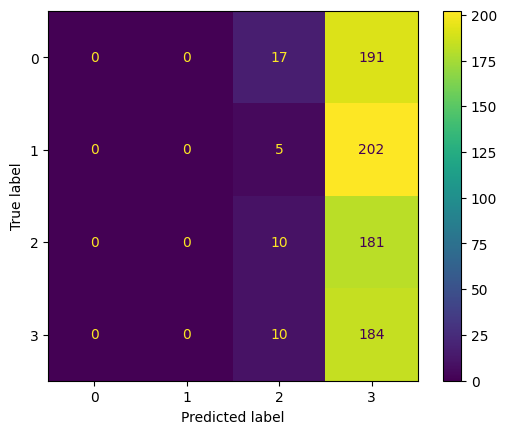

In [35]:
knn = pickle.load(open("knn_classifier.pkl", "rb"))


y_pred = knn.predict(X_test)


print(accuracy_score(y_test, y_pred) * 100)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=[0, 1, 2, 3]
)
cm_display.plot()
plt.show()

In [39]:
svm_classifier = svm.SVC(decision_function_shape="ovr")
svm_classifier.fit(X_train, y_train)
with open( 'svm_classifier.pkl', 'wb') as file:
    pickle.dump(svm_classifier, file)

23.875


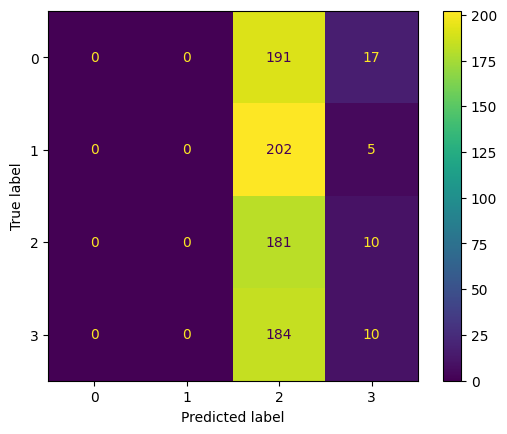

In [40]:
svm_classifier = pickle.load(open("svm_classifier.pkl", "rb"))


y_pred = svm_classifier.predict(X_test)



print(accuracy_score(y_test, y_pred)*100)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=[0, 1, 2, 3]
)
cm_display.plot()
plt.show()